In [1]:
import pandas
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

C:\Users\aau1\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\compat\_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.1.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
df = pandas.read_csv("data/AAPL.csv")

In [3]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-09-05,228.990005,229.669998,225.100006,226.869995,223.403275,33333000
1,2018-09-06,226.229996,227.350006,221.300003,223.100006,219.690903,34290000
2,2018-09-07,221.850006,225.369995,220.710007,221.300003,217.918411,37619800
3,2018-09-10,220.949997,221.850006,216.470001,218.330002,214.993759,39516500
4,2018-09-11,218.009995,224.300003,216.559998,223.850006,220.429443,35749000
...,...,...,...,...,...,...,...
247,2019-08-29,208.500000,209.320007,206.660004,209.009995,209.009995,20990500
248,2019-08-30,210.160004,210.449997,207.199997,208.740005,208.740005,21143400
249,2019-09-03,206.429993,206.979996,204.220001,205.699997,205.699997,20023000
250,2019-09-04,208.389999,209.479996,207.320007,209.190002,209.190002,19188100


In [4]:
dfreg = df.loc[:,["Adj Close","Volume"]]
dfreg["Date"] = pandas.to_datetime(df['Date'])
dfreg["HL_PCT"] = (df["High"] - df["Low"]) / df["Close"] * 100.0
dfreg["PCT_change"] = (df["Close"] - df["Open"]) / df["Open"] * 100.0
dfreg = dfreg.set_index('Date')

C:\Users\aau1\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\compat\_optional.py:106: UserWarning: Pandas requires version '2.6.2' or newer of 'numexpr' (version '2.6.1' currently installed).
  warnings.warn(msg, UserWarning)


In [5]:
dfreg

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2018-09-05,223.403275,33333000,2.014366,-0.925809
2018-09-06,219.690903,34290000,2.711790,-1.383543
2018-09-07,217.918411,37619800,2.105733,-0.247917
2018-09-10,214.993759,39516500,2.464162,-1.185786
2018-09-11,220.429443,35749000,3.457675,2.678781
...,...,...,...,...
2019-08-29,209.009995,20990500,1.272668,0.244602
2019-08-30,208.740005,21143400,1.556961,-0.675675
2019-09-03,205.699997,20023000,1.341757,-0.353629


In [6]:
import math
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
#forecast_out = int(math.ceil(0.01 * len(dfreg)))
forecast_out = 10
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = sklearn.preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)#, shuffle=False)

In [8]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# SVR
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_rbf.fit(X_train, y_train)
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [9]:
confidencereg = clfreg.score(X_test, y_test) #0.6268349679841989
confidencesvr = svr_rbf.score(X_test,y_test) #0.4571830631098365
confidenceknn = clfknn.score(X_test, y_test) #0.47697790543220403

In [10]:
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan

In [11]:
forecast_set

array([210.69065217, 196.81646058, 205.28330354, 204.22119413,
       205.83997749, 208.05459731, 208.59461722, 206.26639295,
       208.69133659, 211.38063037])

In [12]:
dfreg.tail(50)

,Adj Close,Volume,HL_PCT,PCT_change,label,Forecast
Date,,,,,,
2019-06-26,199.043747,26067500,1.821821,1.026444,200.986359,NaN
2019-06-27,198.983978,20899700,1.001302,-0.274596,202.530502,NaN
2019-06-28,197.170853,31110600,1.237872,-0.382522,204.433273,NaN
2019-07-01,200.787125,27316700,1.905240,-0.797359,203.725952,NaN
2019-07-02,201.962646,16935200,0.873084,0.655376,202.580307,NaN
2019-07-03,203.636292,11362000,0.856122,0.555886,204.881561,NaN
2019-07-05,203.456970,17265500,1.067428,0.432746,201.823181,NaN
2019-07-08,199.262909,25338600,1.494845,-0.393404,206.435654,NaN
2019-07-09,200.478302,20578000,1.341680,1.024100,208.049515,NaN


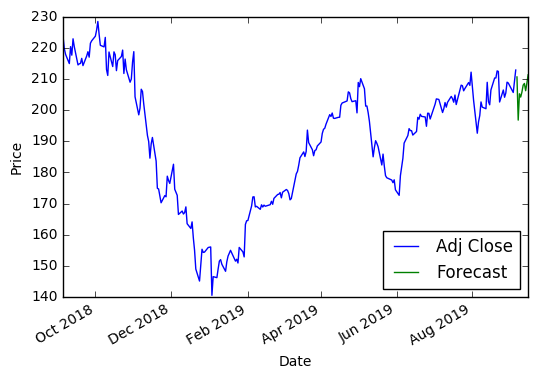

In [13]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()